# plotting av test



## import libraries


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

## load files

In [27]:
# --- AD2 data paths---
point_five_ohm_decouple = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/0.5ohm_30uF_decouple_AD2.csv'
point_five_ohm = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/0.5ohm_AD2.csv'
one_ohm_decouple = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/1ohm_30uF_decouple_AD2.csv'
one_ohm = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/1ohm_AD2.csv'
ten_ohm_decouple = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/10ohm_30uF_decouple_AD2.csv'
ten_ohm = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/10ohm_AD2.csv'
hundered_ohm_decouple = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/100ohm_30F_decouple_AD2.csv'
hundered_ohm = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype/100ohm_AD2.csv'


# Load the CSV file
data_point_five_d = pd.read_csv(point_five_ohm_decouple, names=['Time', 'Voltage'])
data_point_five = pd.read_csv(point_five_ohm, names=['Time', 'Voltage'])
data_one_d = pd.read_csv(one_ohm_decouple, names=['Time', 'Voltage'])
data_one = pd.read_csv(one_ohm, names=['Time', 'Voltage'])
data_ten_d = pd.read_csv(ten_ohm_decouple, names=['Time', 'Voltage'])
data_ten = pd.read_csv(ten_ohm, names=['Time', 'Voltage'])
data_hundered_d = pd.read_csv(hundered_ohm_decouple, names=['Time', 'Voltage'])
data_hundered = pd.read_csv(hundered_ohm, names=['Time', 'Voltage'])

## Sammenligning outpur vs ekstra decoupling capacitors
with ouliners (old)

In [9]:
# --- Set your paths ---
input_folder = '/Users/aslakoverengiveland/Dataplotting/data_siste_prototype'
output_folder = '/Users/aslakoverengiveland/Dataplotting/plots'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Find all CSV files
csv_files = glob.glob(os.path.join(input_folder, '*.csv'))

# Check if any files were found
if not csv_files:
    print("No CSV files found in the specified folder.")
    exit()

# Extract available resistor values (assuming filename format helps, e.g., '1ohm_normal.csv', '1ohm_decouple.csv')
resistor_values = set()
for file in csv_files:
    basename = os.path.basename(file)
    # Assuming filenames like '1ohm_normal.csv' or '1ohm_decouple.csv'
    resistor = basename.split('_')[0]
    resistor_values.add(resistor)

resistor_values = sorted(list(resistor_values))

# Let user pick resistor value
print("Available resistor values:")
for idx, resistor in enumerate(resistor_values):
    print(f"[{idx}] {resistor}")

resistor_index = int(input("Enter the number of the resistor you want to plot: "))
chosen_resistor = resistor_values[resistor_index]

# Find the files for this resistor
normal_file = None
decouple_file = None

for file in csv_files:
    basename = os.path.basename(file).lower()
    if chosen_resistor.lower() in basename:
        if 'decouple' in basename:
            decouple_file = file
        else:
            normal_file = file

# Check that both files exist
if not normal_file or not decouple_file:
    print("Could not find both normal and decoupled files for this resistor.")
    exit()

# Load the data
normal_data = pd.read_csv(normal_file, names=['Time', 'Voltage'])
decouple_data = pd.read_csv(decouple_file, names=['Time', 'Voltage'])

# Calculate statistics
normal_nominal = normal_data['Voltage'].mean()
normal_ptp = normal_data['Voltage'].max() - normal_data['Voltage'].min()

decouple_nominal = decouple_data['Voltage'].mean()
decouple_ptp = decouple_data['Voltage'].max() - decouple_data['Voltage'].min()

# Plotting both

def plot_and_save(data, title, filename, nominal_voltage, ptp_voltage):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Zoom to first 10 ms
    time_window = 0.001
    time_start = data['Time'].min()
    time_end = time_start + time_window
    mask = (data['Time'] >= time_start) & (data['Time'] <= time_end)
    
    ax.plot(data['Time'][mask], data['Voltage'][mask], lw=1)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title(title)
    ax.grid(True)
    
    # Statistics text
    stats_text = (f"Nominal Voltage: {nominal_voltage:.3f} V\n"
                  f"Peak-to-Peak: {ptp_voltage:.3f} V")
    ax.text(0.02, 0.95, stats_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Save plot
    save_path = os.path.join(output_folder, filename)
    plt.savefig(save_path)
    print(f"Saved plot: {save_path}")
    plt.show()

# Plot and save normal
plot_and_save(
    normal_data,
    title=f'{chosen_resistor} Normal',
    filename=f'{chosen_resistor}_normal.png',
    nominal_voltage=normal_nominal,
    ptp_voltage=normal_ptp
)

# Plot and save decoupled
plot_and_save(
    decouple_data,
    title=f'{chosen_resistor} Decoupled',
    filename=f'{chosen_resistor}_decoupled.png',
    nominal_voltage=decouple_nominal,
    ptp_voltage=decouple_ptp
)

Available resistor values:
[0] 0.5ohm
[1] 100ohm
[2] 10ohm
[3] 1ohm


ValueError: invalid literal for int() with base 10: ''

### ett bilde

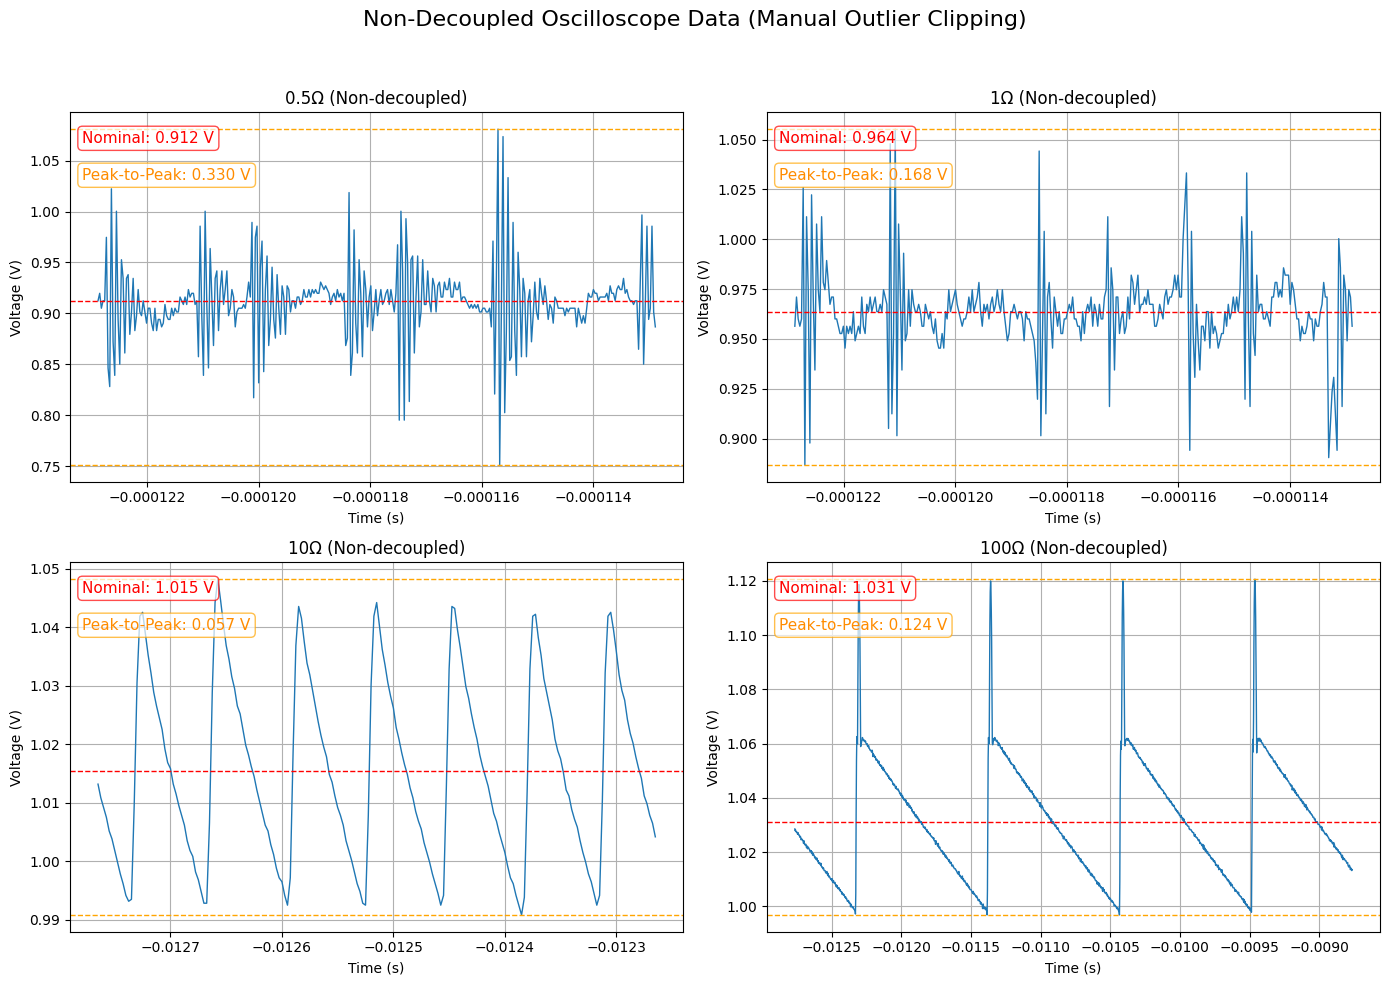

In [43]:

# --- Manual spike-removal helper ---
def clip_outliers_fixed_bounds(series, nominal, threshold):
    return series[(series >= nominal - threshold) & (series <= nominal + threshold)]

# --- Plot 4 datasets with custom zooms and fixed clipping for 10Ω and 1Ω ---

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Map labels, data, time window, and optional clip thresholds
datasets = {
    '0.5Ω': (data_point_five, 1e-5, None),
    '1Ω':   (data_one,        1e-5, 0.100),  # ±100 mV
    '10Ω':  (data_ten,       5e-4, 0.035),  # ±35 mV
    '100Ω': (data_hundered,  4e-3, None)
}

# Plot each
for i, (label, (data, time_window, clip_threshold)) in enumerate(datasets.items()):
    ax = axs[i]

    # Zoom mask
    t_start = data['Time'].min()
    t_end = t_start + time_window
    mask = (data['Time'] >= t_start) & (data['Time'] <= t_end)

    time_zoom = data['Time'][mask]
    voltage_zoom = data['Voltage'][mask]

    # First get nominal from full zoomed data
    nominal = voltage_zoom.mean()

    # If clipping threshold defined, remove outliers
    if clip_threshold is not None:
        voltage_zoom = clip_outliers_fixed_bounds(voltage_zoom, nominal, clip_threshold)
        time_zoom = time_zoom[voltage_zoom.index]  # align time to cleaned voltage
        nominal = voltage_zoom.mean()  # recalculate nominal after cleaning

    ptp = voltage_zoom.max() - voltage_zoom.min()
    upper_ripple = voltage_zoom.max()
    lower_ripple = voltage_zoom.min()

    # Plot waveform
    ax.plot(time_zoom, voltage_zoom, lw=1)
    
    # Nominal and ripple bounds
    ax.axhline(nominal, color='red', linestyle='--', linewidth=1)
    ax.axhline(upper_ripple, color='orange', linestyle='--', linewidth=1)
    ax.axhline(lower_ripple, color='orange', linestyle='--', linewidth=1)

    # Labels and title
    ax.set_title(f'{label} (Non-decoupled)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')
    ax.grid(True)

    # Stats text boxes
    ax.text(0.02, 0.95, f"Nominal: {nominal:.3f} V", transform=ax.transAxes,
            fontsize=11, verticalalignment='top', color='red',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='red'))

    ax.text(0.02, 0.85, f"Peak-to-Peak: {ptp:.3f} V", transform=ax.transAxes,
            fontsize=11, verticalalignment='top', color='darkorange',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='orange'))

plt.suptitle('Non-Decoupled Oscilloscope Data (Manual Outlier Clipping)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()






## Calculations
nominal voltage, peak to peak (ripple), difference from goals (1V, $\pm 30mV$)

In [44]:
# --- Calculate nominal, peak-to-peak, and deviations from target with manual spike filtering ---

# Target specs
target_voltage = 1.000       # Volts
max_ripple_pp = 0.060        # 60 mV peak-to-peak

# Results dictionary
results = {}

# Use same dataset + clipping rules as in plot
datasets = {
    '0.5Ω': (data_point_five, None),
    '1Ω':   (data_one,        0.100),  # ±100 mV
    '10Ω':  (data_ten,        0.035),  # ±35 mV
    '100Ω': (data_hundered,   None)
}

for label, (data, clip_threshold) in datasets.items():
    voltage = data['Voltage']
    nominal = voltage.mean()

    if clip_threshold is not None:
        voltage = clip_outliers_fixed_bounds(voltage, nominal, clip_threshold)
        nominal = voltage.mean()  # Recalculate after clipping

    peak_to_peak = voltage.max() - voltage.min()
    voltage_error = nominal - target_voltage
    ripple_error = peak_to_peak - max_ripple_pp

    results[label] = {
        'Nominal (V)': nominal,
        'Peak-to-Peak (V)': peak_to_peak,
        'ΔV (vs 1V)': voltage_error,
        'ΔRipple (vs ±30mV)': ripple_error
    }

# Print summary
print("Voltage and Ripple Analysis (with spike removal):\n")
for label, stats in results.items():
    print(f"{label}:")
    print(f"  Nominal Voltage                           : {stats['Nominal (V)']:.3f} V")
    print(f"  Peak-to-Peak Voltage                      : {stats['Peak-to-Peak (V)']:.3f} V")
    print(f"  Offset from 1.000 V                       : {stats['ΔV (vs 1V)']:+.3f} V")
    print(f"  Difference from desired ripple (±30 mV)   : {stats['ΔRipple (vs ±30mV)']:+.3f} V\n")


Voltage and Ripple Analysis (with spike removal):

0.5Ω:
  Nominal Voltage                           : 0.907 V
  Peak-to-Peak Voltage                      : 0.352 V
  Offset from 1.000 V                       : -0.093 V
  Difference from desired ripple (±30 mV)   : +0.292 V

1Ω:
  Nominal Voltage                           : 0.960 V
  Peak-to-Peak Voltage                      : 0.198 V
  Offset from 1.000 V                       : -0.040 V
  Difference from desired ripple (±30 mV)   : +0.138 V

10Ω:
  Nominal Voltage                           : 1.016 V
  Peak-to-Peak Voltage                      : 0.059 V
  Offset from 1.000 V                       : +0.016 V
  Difference from desired ripple (±30 mV)   : -0.001 V

100Ω:
  Nominal Voltage                           : 1.031 V
  Peak-to-Peak Voltage                      : 0.125 V
  Offset from 1.000 V                       : +0.031 V
  Difference from desired ripple (±30 mV)   : +0.065 V



# plotting av simulering
